In [1]:
# Load all packages
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from keras.utils import plot_model
import matplotlib.pyplot as plt

import survivalnet2
from survivalnet2.data.datasets import dataset
from survivalnet2.losses import efron
from survivalnet2.metrics.concordance import HarrellsC

# Set a global seed
np.random.seed(51)
tf.keras.utils.set_random_seed(51)

In [2]:
physical_devices = tf.config.list_physical_devices()
physical_devices

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.config.set_visible_devices([], 'GPU')

In [4]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# NAM Functions

In [5]:
def preprocessing(features, label, train_ratio):  
    """Generate tf dataset for training and testing of the NAM model, as well as input layers.
    
    Parameters
    ----------
    features: array-like
        An N x D array of D-dimensional features for N subjects.
    label: array-like
        An array of either progression free interval (pfi) or overall survival (osr) label. Each is an N x 2 array of survival or last followup
        times and event status (a value of 1 indicates an event was observed). 
    train_ratio: float32
        A train set ratio for train/test split.
    index: array-like
        
    Returns
    -------
    all_train_features: array-like
        An array containing D elements, each a feature for N train subjects.
    all_test_features: array-like
        An array containing D elements, each a feature for N test subjects.
    all_input: array-like
        A D x 1 array of tf.keras.Input tensors of input shape 1.
    y_train: array-like
        An array of train data of either progression free interval (pfi) or overall survival (osr) label.
    y_test: array-like
        An array of test data of either progression free interval (pfi) or overall survival (osr) label.
   
    """  
    # Get feature shape
    (N, D) = features.shape
    
    # Generate train/test split
    index = np.argsort(np.random.rand(N))
    train = np.zeros(N, np.bool_)
    train[index[0 : int(train_ratio * N)].astype(np.int32)] = True
    test = ~train
    
    # Create tf dataset for each feature & input set
    all_train_features = []
    all_test_features = []
    all_input = []
    y_train = label[train, :]
    y_test = label[test, :]
    for i in range(D):
        all_train_features.append(features[:, i][train])
        all_test_features.append(features[:, i][test])
        all_input.append(tf.keras.Input(shape=(1,)))
        
    return all_train_features, all_test_features, all_input, y_train, y_test

In [6]:
def NAM_model(features, label, train_ratio, config):
    """Build a NAM model according to the input configurations of the sub-ANN models
    
    Parameters
    ----------
    features: array-like
        An N x D array of D-dimensional features for N subjects.
    label: array-like
        An array of either progression free interval (pfi) or overall survival (osr) label.
        Each is an N x 2 array of survival or last followup times and event status (a value of 1 
        indicates an event was observed). 
    train_ratio: float32
        A train set ratio for train/test split.
    config: dict
        A dictionary with the first key as "units", a list of number of units for each dense layer
        of the sub-ANN models, and the second key as "activation", a list of all activation functions
        for each dense layer.
        
    Returns
    -------
    model: tf.keras.Model
        The NAM model.
    all_models: array-like
        An array of tf.keras.Model for each of the sub-ANN models in the NAM model
   
    """          
    def _build_dense_layer(units, activation):
    # Dense layers   
        return tf.keras.layers.Dense(units=units, activation=activation)

    # Define train and test set. Define all input to the NAM model
    all_train_features, all_test_features, all_input, y_train, y_test = preprocessing(features, label, train_ratio)

    # Build ANN architecture for each feature
    all_models = []
    for each_input in all_input:
        dense = []
        for i, (u, a) in enumerate(zip(config["units"], config["activation"])):
            if i == 0:
                dense.append(_build_dense_layer(u, a)(each_input))
            else:
                dense.append(_build_dense_layer(u, a)(dense[-1]))        
        all_models.append(tf.keras.Model(inputs=each_input, outputs=_build_dense_layer(1,"linear")(dense[-1])))
        
    combined = tf.math.reduce_sum([each_model.output for each_model in all_models], axis = 0)
    
    # Build NAM model
    model = tf.keras.Model(inputs=[each_model.input for each_model in all_models], outputs=combined)
    
    return model, all_models

In [7]:
def get_contributions(model, all_models, all_train_features):
    """Get the contributions of each feature of the NAM model.
    
    Parameters
    ----------
    all_models: array-like
        An array of tf.keras.Model for each of the sub-ANN models in the NAM model
    all_train_features: array-like
        An N x D array D-dimensional features for N train subjects.    
        
    Returns
    -------
    contributions: array-like
        A D x 1 array of float32 containing contributions of each feature to the NAM model.  
    """          
    
    contributions = []
    for i in range(len(all_models)):
        contributions.append(np.concatenate(all_models[i].predict(all_train_features[i])))
        
    return contributions

## Example

In [8]:
# Load protein expression features (continuous variables)
features, names, labels, description = dataset("tcga_glioma")
pfi = labels["pfi"]
names = names[222:227]
features = features[:, 222:227]

In [9]:
# Preprocess data
all_train_features, all_test_features, all_input, y_train, y_test = preprocessing(features, pfi, 0.8)

In [10]:
# Determine configuration of all sub-ANN models in the NAM model
config = {"units": [16, 8], "activation": ["selu", "selu"]}

In [11]:
# Build the NAM model
nam, all_models = NAM_model(features, pfi, 0.8, config)

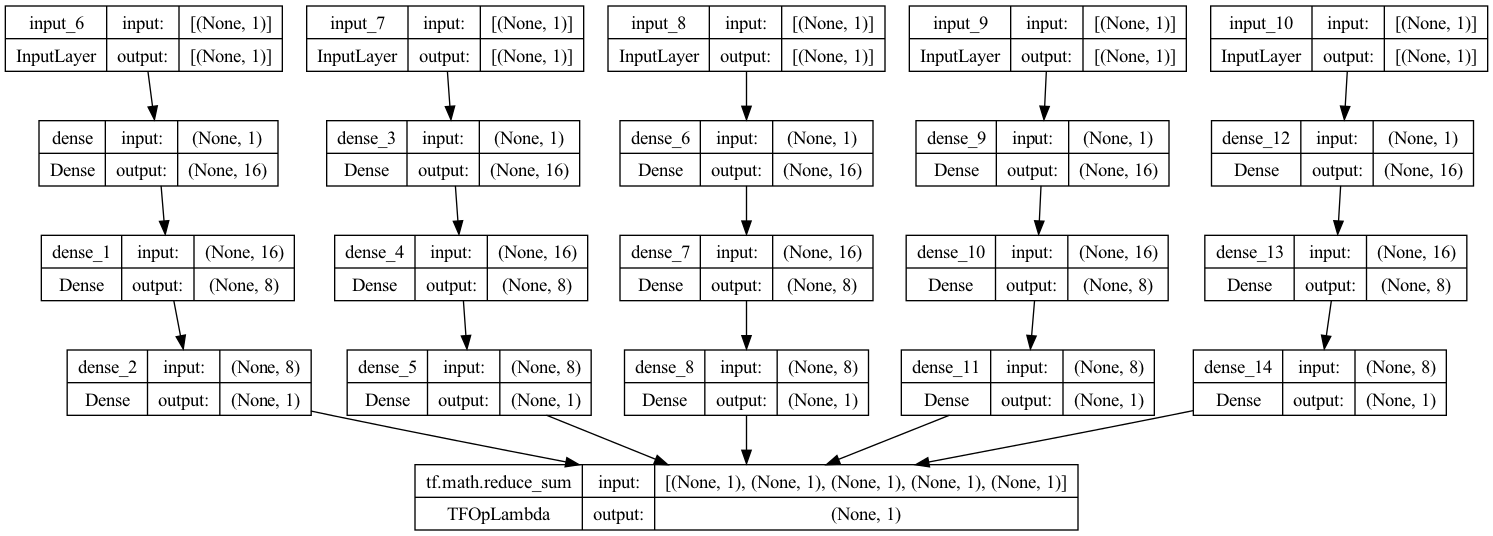

In [12]:
# Check NAM's graph
plot_model(nam, show_shapes = True)

In [13]:
# Train the NAM Model using efron loss
nam.compile(
    loss=efron,
    metrics=[HarrellsC()],
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
)
nam.fit(x = all_train_features, y = y_train, epochs=200, verbose=1)

Epoch 1/200


2023-06-30 16:57:41.761535: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15/15 [==============================] - 2s 5ms/step - loss: 44.3521 - harrellsc: 0.4808
Epoch 2/200
15/15 [==============================] - 0s 3ms/step - loss: 44.1246 - harrellsc: 0.4837
Epoch 3/200
15/15 [==============================] - 0s 3ms/step - loss: 44.6580 - harrellsc: 0.4710
Epoch 4/200
15/15 [==============================] - 0s 3ms/step - loss: 43.6073 - harrellsc: 0.4868
Epoch 5/200
15/15 [==============================] - 0s 3ms/step - loss: 43.4851 - harrellsc: 0.4926
Epoch 6/200
15/15 [==============================] - 0s 3ms/step - loss: 42.9158 - harrellsc: 0.4874
Epoch 7/200
15/15 [==============================] - 0s 3ms/step - loss: 43.2690 - harrellsc: 0.4843
Epoch 8/200
15/15 [==============================] - 0s 3ms/step - loss: 42.8477 - harrellsc: 0.4873
Epoch 9/200
15/15 [==============================] - 0s 3ms/step - loss: 43.0698 - harrellsc: 0.4981
Epoch 10/200
15/15 [==============================] - 0s 3ms/step - loss: 43.3088 - harrellsc: 0.4869
E

15/15 [==============================] - 0s 3ms/step - loss: 39.7988 - harrellsc: 0.6345
Epoch 82/200
15/15 [==============================] - 0s 3ms/step - loss: 40.2552 - harrellsc: 0.6386
Epoch 83/200
15/15 [==============================] - 0s 3ms/step - loss: 40.2787 - harrellsc: 0.6513
Epoch 84/200
15/15 [==============================] - 0s 3ms/step - loss: 40.2282 - harrellsc: 0.6403
Epoch 85/200
15/15 [==============================] - 0s 3ms/step - loss: 40.1403 - harrellsc: 0.6438
Epoch 86/200
15/15 [==============================] - 0s 3ms/step - loss: 39.6362 - harrellsc: 0.6611
Epoch 87/200
15/15 [==============================] - 0s 3ms/step - loss: 40.3973 - harrellsc: 0.6426
Epoch 88/200
15/15 [==============================] - 0s 3ms/step - loss: 39.5811 - harrellsc: 0.6382
Epoch 89/200
15/15 [==============================] - 0s 3ms/step - loss: 40.1336 - harrellsc: 0.6555
Epoch 90/200
15/15 [==============================] - 0s 3ms/step - loss: 40.1997 - harrellsc: 

15/15 [==============================] - 0s 3ms/step - loss: 39.8121 - harrellsc: 0.6589
Epoch 162/200
15/15 [==============================] - 0s 3ms/step - loss: 39.6956 - harrellsc: 0.6492
Epoch 163/200
15/15 [==============================] - 0s 3ms/step - loss: 40.3091 - harrellsc: 0.6584
Epoch 164/200
15/15 [==============================] - 0s 3ms/step - loss: 39.6038 - harrellsc: 0.6524
Epoch 165/200
15/15 [==============================] - 0s 3ms/step - loss: 39.5931 - harrellsc: 0.6552
Epoch 166/200
15/15 [==============================] - 0s 3ms/step - loss: 39.8576 - harrellsc: 0.6526
Epoch 167/200
15/15 [==============================] - 0s 3ms/step - loss: 40.4117 - harrellsc: 0.6510
Epoch 168/200
15/15 [==============================] - 0s 3ms/step - loss: 39.6650 - harrellsc: 0.6577
Epoch 169/200
15/15 [==============================] - 0s 3ms/step - loss: 40.0319 - harrellsc: 0.6520
Epoch 170/200
15/15 [==============================] - 0s 3ms/step - loss: 39.8826 - ha

In [14]:
# Evaluate on test data
risks = nam.predict(all_test_features)
cindex = HarrellsC()
print("Testing c-index: %0.3f" % cindex(y_test, risks))

4/4 [==============================] - 0s 747us/step
Testing c-index: 0.728


15/15 [==============================] - 0s 337us/step


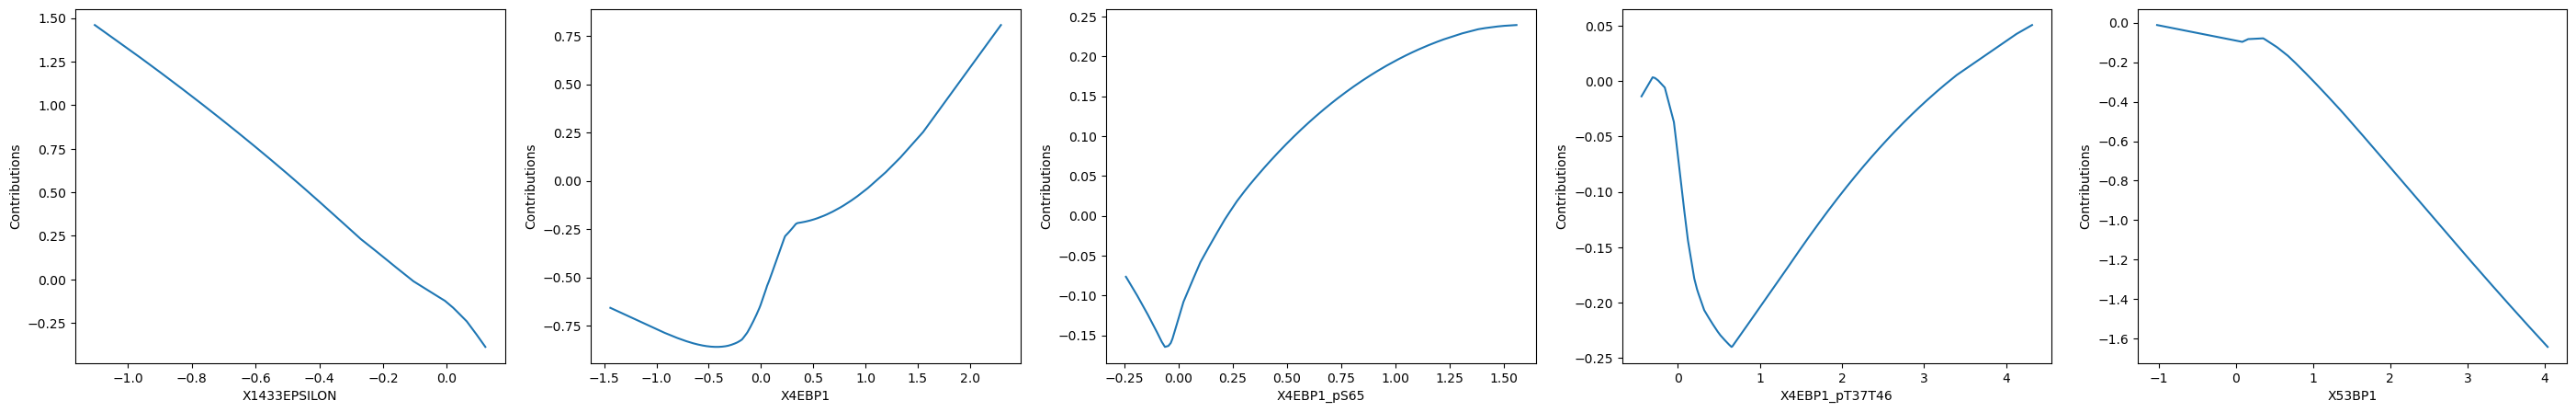

In [15]:
# Plot contributions vs. features
contributions = get_contributions(nam, all_models, all_train_features)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35,5))
for i in range(5):
    sns.lineplot(x = all_train_features[i], y = contributions[i], ax=axes[i])
    axes[i].set_xlabel(names[i])
    axes[i].set_ylabel("Contributions")